# Interpolating Control

The Interpolating Control (IC) is implemented in this notebook using CVXPY package. In IC, there is solved simple Linear Program (LP) in each time step. CVXPY serves as a universal Python interface (similarly to well known Yalmip for Matlab).

As the LP solver, Gurobi is employed  because of results in [1]. Nevertherless, thanks to CVXPY, solver can be switched simply by changing one parameter.

## Imports

In [1]:
import cvxpy as cp
import numpy as np
from scipy.io import loadmat
import polytope as pc
import pickle
import pandas as pd
import time
from nonlinear_dynamics import discreteUav, uavPlanarNonlin

import matplotlib.pyplot as plt
from statemodel import StateModel
from control_cascade import ControlCascade

## Loading data

Parameters of UAV model are based on [2].

In [2]:
# load model data
model_data_folder = "params"
models_file = {"lateral", "altitude"}

# Load parameters of dynamics and cost function
models = []
for model_file in models_file:
    with open(model_data_folder+"/"+"ctrl_"+model_file+".pkl", 'rb') as infile:
        models.append(pickle.load(infile))
        
with open(model_data_folder+"/"+"ctrl_"+"attitude"+".pkl", 'rb') as infile:
    model_att = pickle.load(infile)

In [5]:
print(model_att.K_h, model_att.L_h)
# print(model_att.K_l, model_att.L_l)
print(model_att.Q_h, model_att.R_h)

[[-14.32695  -1.49533]] [[14.32695 -0.     ]]
[[32.82806  0.     ]
 [ 0.       0.32828]] 0.12274441735371766


In [6]:
# print(model_att.K_l, model_att.L_l)
print(model_att.sys.A, model_att.sys.B)

[[1.    0.001]
 [0.    1.   ]] [[0.00008]
 [0.15625]]


In [10]:
print(models[1].sys.A, models[1].sys.B)
print(models[1].Q_h, models[1].R_h)
print(models[1].K_h, models[1].L_h)

[[1.   0.01]
 [0.   1.  ]] [[0.0001]
 [0.02  ]]
[[4.   0.  ]
 [0.   0.16]] 29.48340113618408
[[-0.36609 -0.60947]] [[ 0.00001  0.00011  0.00004 ...  0.      -0.00003  0.     ]]


## Set up problem

In [3]:
# init controllers
types = ['ic', 'mpc', 'mpcmb']
cascades = []
for type in types:
    cascades.append(ControlCascade(type, models, True))
    # u = ctrl_ic.spin(rk[:,:N], xk_ic[:,0])

In [31]:
# Initialization and data for saving the solution
rk = np.zeros((6,5000))
rk[(0,1),100:] = 1
x0 = np.zeros((6,1))
N = 800
xk_ic = np.zeros((6,N+1))
# xk_ic[:,0] = x0
uk_ic = np.zeros((2,N))
times_ic = np.zeros((N,1))
times_ic_lqr = np.zeros((N,1))
ck = np.zeros((N+1,1))



## Run simulation

In [40]:
for cascade in cascades:
    xk = x0
    for i in range(1,cascade.models[0].N+1):
        # Set current trajectory and setpoint.
        # time1 = time.time()
        # Save data.
        uk_att_ref, uk_thrust = cascade.spin(rk[:,(i-1):i+models[0].N-1], xk)
        # times_ic_lqr[i-1,j] = time.time()-time1-times_ic[i-1,j]
        # Run system dynamics.
        for i in range(10):
            uk_torque = model_att.K_h@xk[[2,5],0] + model_att.L_h@[uk_att_ref[0,0],0]
            xk = discreteUav(xk, np.array([uk_thrust[0,0], uk_torque[0,0]]), model_att.dt)

/home/zboucek/anaconda3/envs/ic/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

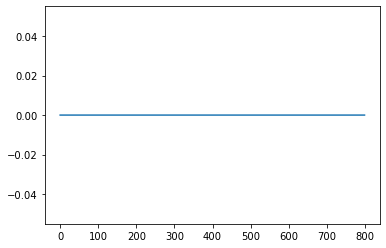

In [15]:
plt.step(range(0,models[0].N),xk_ic[0,0:models[0].N])

In [ ]:
discreteUav(np.ones((6,1)), np.random.randn(2, 1), 1e-3)

array([[1.001  ],
       [1.001  ],
       [1.001  ],
       [0.99919],
       [0.99071],
       [1.05682]])

## Save using Pandas to CSV

In [ ]:
dict_ic = {'Timestamp': np.arange(0,N*models[0].dt,models[0].dt),
            'State1': xk_ic[0,1:N+1], 'State2': xk_ic[1,1:N+1],
            'Control': uk_ic[0,:N],
            'Ref1': rk[0,:N], 'Ref2': rk[1,:N],
            'Err1': xk_ic[0,1:N+1] - rk[0,:N],
            'Err2': xk_ic[1,1:N+1] - rk[1,:N],
            #'Time Comp.': times_ic[:N,0],
            'Time Comp.': times_ic[:N,0]+times_ic_lqr[:N,0]}
df_ic = pd.DataFrame(dict_ic)
df_ic.to_csv('sim_ic.csv',sep='\t',index=False,header=True)

# Model Predictive Control

Model Predictive Control (MPC) will be covered for in two distinct implementations. First, the standard MPC will be implemented. Afterwards, a computationally more efficient alternative using the move blocking scheme. For the sake of efficiency, varying control input is considered only for small numer of time instants and for later for longer time periods it is constant.

In [ ]:
xk_mpc = np.zeros((nx,N+1))
xk_mpc[:,0] = x0
uk_mpc = np.zeros((nu,N))
times_mpc = np.zeros((N,Nsims))
u = cp.Variable((nu,N))
x = cp.Variable((nx,N+1))
r = cp.Parameter((nx,N+1))
x_init = cp.Parameter(nx)

NameError: name 'nx' is not defined

In [ ]:
# Objective function and constraints.
cost_mpc = 0
constraints_mpc = [x[:,0] == x_init]
for k in range(N):
    cost_mpc += cp.quad_form(x[:,k]-r[:,k], Q1) 
    cost_mpc += cp.quad_form(u[:,k], np.array([[R1]]))
    constraints_mpc += [x[:,k+1] == A@x[:,k] + B@u[:,k]]
    constraints_mpc += [xlim.A@x[:,k] <= xlim.b]
    constraints_mpc += [ulim.A@u[:,k] <= ulim.b]
    
objective_mpc = cp.Minimize(cost_mpc)
prob_mpc = cp.Problem(objective_mpc, constraints_mpc)

for j in range(Nsims):
    x_init.value = x0
    for i in range(1,N+1):
        # Set current trajectory.
        r.value = rk[:,i:i+N+1]
        
        # Find control strategy.
        result = prob_mpc.solve(solver)
        
        # Save data.
        uk_mpc[:,i-1] = u[:,0].value
        # Run system dynamics.
        x_init.value = A@x_init.value + B@uk_mpc[:,i-1]
        xk_mpc[:,i] = x_init.value
        times_mpc[i-1,j] = prob_mpc.solver_stats.solve_time

In [ ]:
dict_mpc = {'Timestamp': np.arange(0,N*dt,dt),
            'State1': xk_mpc[0,1:N+1], 'State2': xk_mpc[1,1:N+1],
            'Control': uk_mpc[0,:N],
            'Ref1': rk[0,:N], 'Ref2': rk[1,:N],
            'Err1': xk_mpc[0,1:N+1] - rk[0,:N],
            'Err2': xk_mpc[1,1:N+1] - rk[1,:N],
            'Time Comp.': times_mpc[:N,0]}
df_mpc = pd.DataFrame(dict_mpc)
df_mpc.to_csv('sim_mpc.csv',sep='\t',index=False,header=True)

# MPC with move blocking

In the first step, the dynamics is conscidered as fast as in the standard model. However, in latter steps the discrete system has much slower period from $T_s = 0.01$ to $T_s = 0.2$. Because of the change, the weights in criterion must be altered accordingly. Therefore, weights are multipled by 10 for i=2:N horizon. The change is not reflected in the evaluation of controller performance, the same criterion is employed.

In [ ]:
xk_mpc_block = np.zeros((nx,N+1))
xk_mpc_block[:,0] = x0
Ublock = [1,1,1,1,1,5,5,5,5,5,10]
Nblock = np.sum(Ublock)
Uindex = np.zeros(np.shape(Ublock))
for k in range(len(Ublock)):
    Uindex[k] = np.sum(Ublock[:k])
uk_mpc_block = np.zeros((nu,N))
times_mpc_block = np.zeros((N,Nsims))
u = cp.Variable((nu,np.size(Ublock)))
x = cp.Variable((nx,Nblock+1))
r = cp.Parameter((nx,Nblock+1))
x_init = cp.Parameter(nx)
Ad = np.copy(A)
Bd = np.copy(B)
Qd = np.copy(Q1)
Rd = np.copy(R1)
dtd = dt

In [ ]:
# Objective function and constraints.
cost_mpc_block = 0
constraints_mpc_block = [x[:,0] == x_init]
for k in range(Nblock):
    j = np.where(Uindex == k)
    if np.size(j) != 0:
        u_idx = j[0][0]
    cost_mpc_block += cp.quad_form(x[:,k]-r[:,k], Qd)
    cost_mpc_block += cp.quad_form(u[:,u_idx], np.array([[Rd]]))
    constraints_mpc_block += [x[:,k+1] == Ad@x[:,k] + Bd@u[:,u_idx]]
    constraints_mpc_block += [xlim.A@x[:,k] <= xlim.b]
    constraints_mpc_block += [ulim.A@u[:,u_idx] <= ulim.b]
    if k == 0:
        dtd = 0.2
        Ad = np.array([[1,dtd],[0,1]])
        Bd = np.array([[0],[dtd]])
        Qd = 10*np.copy(Q1)
        Rd = 10*np.copy(R1)
    
objective_mpc_block = cp.Minimize(cost_mpc_block)
prob_mpc_block = cp.Problem(objective_mpc_block, constraints_mpc_block)

for j in range(Nsims):
    x_init.value = x0
    for i in range(1,N+1):
        # Set current trajectory.
        index = np.concatenate(([i],list(range(i+1,i+N,20))))
        r.value = rk[:,index]
        
        # Find control strategy.
        result = prob_mpc_block.solve(solver)
        
        # Save data.
        uk_mpc_block[:,i-1] = u[:,0].value
        # Run system dynamics.
        x_init.value = A@x_init.value + B@uk_mpc_block[:,i-1]
        xk_mpc_block[:,i] = x_init.value
        times_mpc_block[i-1,j] = prob_mpc_block.solver_stats.solve_time

In [ ]:
dict_mpc_block = {'Timestamp': np.arange(0,N*dt,dt),
                  'State1': xk_mpc_block[0,1:N+1], 'State2': xk_mpc_block[1,1:N+1],
                  'Control': uk_mpc_block[0,:N],
                  'Ref1': rk[0,:N], 'Ref2': rk[1,:N],
                  'Err1': xk_mpc_block[0,1:N+1] - rk[0,:N],
                  'Err2': xk_mpc_block[1,1:N+1] - rk[1,:N],
                  'Time Comp.': times_mpc_block[:N,0]}
df_mpc_block = pd.DataFrame(dict_mpc_block)
df_mpc_block.to_csv('sim_mpc_block.csv',sep='\t',index=False,header=True)

# Bibliography

[1] Z. Bouček and M. Flídr, "Interpolating Control Based Trajectory Tracking*," 2020 16th International Conference on Control, Automation, Robotics and Vision (ICARCV), Shenzhen, China, 2020, pp. 701-706, doi: 10.1109/ICARCV50220.2020.9305511.

[2] T. Baca et al., “Autonomous landing on a moving vehicle with an unmanned aerial vehicle,” J. F. Robot., no. January, 2019.)